In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", context="talk")
import os
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_score

In [3]:
label_dir ='C:/Users/Affinity/Desktop/study/빅콘테스트/2019빅콘테스트_챔피언스리그_데이터_수정/train_label_add.csv'
train_label = pd.read_csv(label_dir)
del train_label['Unnamed: 0']

final_train = pd.read_csv('./final_train.csv')

In [4]:
merge_df = pd.merge(final_train, train_label, on='acc_id', how = 'outer')

In [5]:
merge_df.head()

,acc_id,temp_cnt_x,private_shop,party_exp,pledge_cnt,random_attacker_cnt_x,random_defender_cnt_x,same_pledge_cnt_x,etc_cnt_x,num_opponent,...,amount_spent_3,amount_spent_4,week1_log,week2_log,week3_log,week4_log,survival_time,amount_spent_y,secession,total_spent
0,2,0.000000,84.900753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,1.0,1.000000,1.000000,64,0.000000,0,0.000000
1,5,0.479728,0.000000,0.695285,0.000000,0.000000,0.000000,0.000000,0.000000,0.098129,...,0.000000,0.000000,0.0,0.0,0.142857,0.142857,60,0.000000,1,0.000000
2,8,3.837822,0.000000,0.000000,0.128368,4.270875,0.000000,0.000000,0.225223,1.864446,...,0.000000,0.348521,1.0,1.0,1.000000,1.000000,64,0.020310,0,1.299843
3,17,3.358094,0.000000,8.823094,0.000000,0.000000,2.366129,12.398273,0.563058,1.275674,...,0.000000,0.000000,1.0,1.0,1.000000,1.000000,64,0.070642,0,4.521100
4,20,0.959456,2.917510,0.110339,1.540422,0.000000,2.366129,0.000000,21.621413,13.934283,...,0.826123,0.000000,1.0,1.0,1.000000,1.000000,64,0.052137,0,3.336752


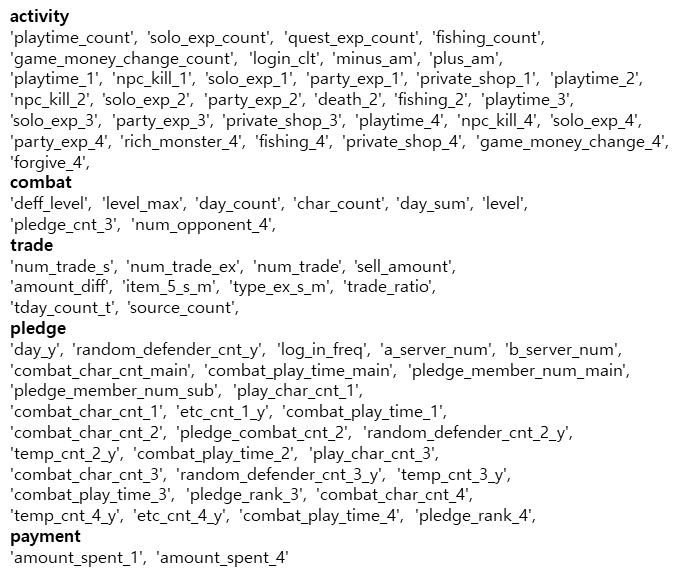

## amount_spent

- amount_spent와 이탈여부의 관계가 높을 것으로 추정했으나 명확한 차이는 얻기 힘듬
    - 실제로 feature importance 찍어보면 30위가 넘어감

In [81]:
payment = merge_df[['amount_spent_1', 'amount_spent_2', 'amount_spent_3', 'amount_spent_4', 'survival_time']]

In [82]:
dic = {}
for i in range(1,64):
    dic[i] = 1
dic[64] = 0

payment['secession'] = payment['survival_time'].map(dic)

C:\ProgramData\Anaconda3\envs\mypython\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [83]:
retain = payment[payment.secession == 0]
churn = payment[payment.secession == 1]

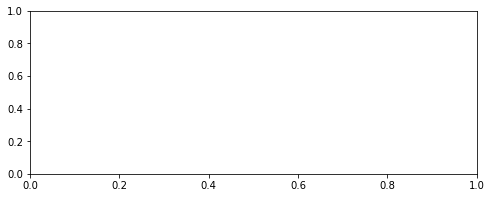

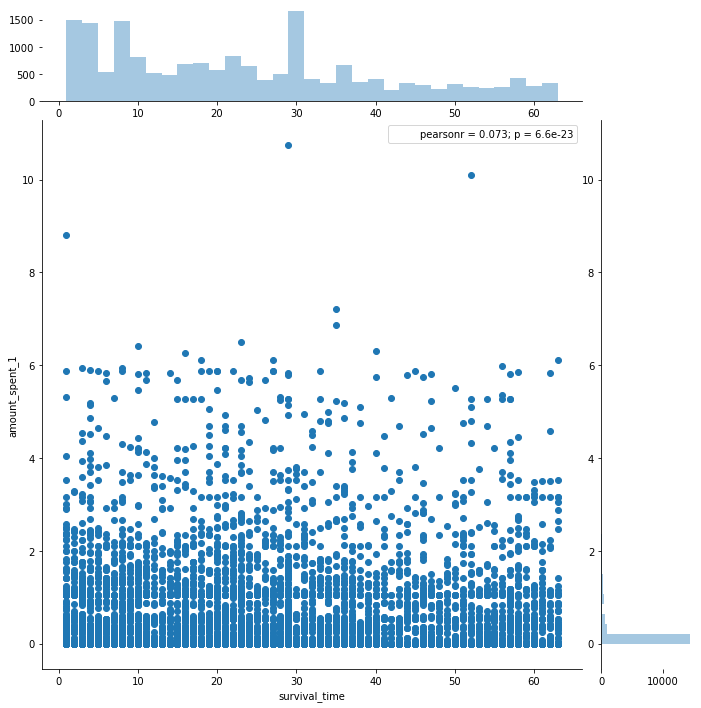

In [65]:
from scipy.stats import gaussian_kde
fig = plt.figure(figsize = (8,3));   
ax1 = fig.add_subplot(111);  
# plt.scatter(churn.survival_time, churn.amount_spent_1)
# plt.hist2d(churn.survival_time, churn.amount_spent_1, (50,50), cmap=plt.cm.jet)
sns.jointplot(x='survival_time', y='amount_spent_1',data = churn, kind='scatter', size = 10)
# xy = np.vstack([churn.survival_time,churn.amount_spent_1])
# z = gaussian_kde(xy)(xy)
# plt.scatter(churn.survival_time, churn.amount_spent_1, c=z, s=100, edgecolor='')

# ax2 = fig.add_subplot(133);
# plt.scatter(retain.survival_time,retain.amount_spent_1)

# sns.jointplot(x=retain.survival_time, y=retain.amount_spent_1, kind='kde', ratio = 1)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (35, 12))
sns.boxplot(y = 'y', x = 'x', data = data, width = 0.8, showmeans = True, fliersize = 3)
plt.show()

In [57]:
payment_group = payment.groupby(['survival_time']).agg('mean').reset_index()
payment_group_median = payment.groupby(['survival_time']).agg('median').reset_index()
payment_group_sum = payment.groupby(['survival_time']).agg('sum').reset_index()

In [77]:
merge_group = merge_df.groupby(['survival_time']).agg('mean').reset_index()
merge_group_median = merge_df.groupby(['survival_time']).agg('median').reset_index()
merge_group_sum = merge_df.groupby(['survival_time']).agg('sum').reset_index()

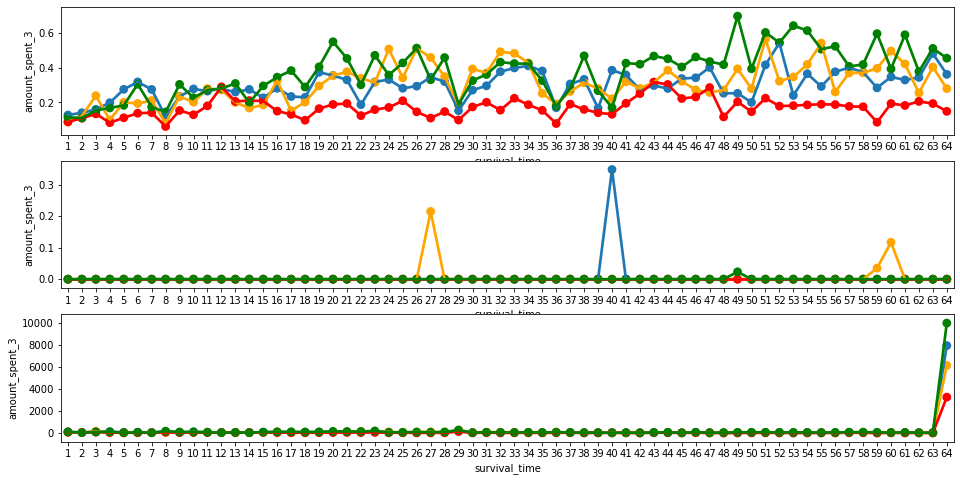

In [78]:
from scipy.stats import gaussian_kde
fig = plt.figure(figsize = (16,8));   
ax1 = fig.add_subplot(311);  
sns.pointplot(data = payment_group, x='survival_time', y='amount_spent_1')
sns.pointplot(data = payment_group, x='survival_time', y='amount_spent_4',color='orange')
sns.pointplot(data = merge_group, x='survival_time', y='amount_spent_2',color='r')
sns.pointplot(data = merge_group, x='survival_time', y='amount_spent_3',color='g')
ax2 = fig.add_subplot(312);  
sns.pointplot(data = payment_group_median, x='survival_time', y='amount_spent_1')
sns.pointplot(data = payment_group_median, x='survival_time', y='amount_spent_4',color='orange')
sns.pointplot(data = merge_group_median, x='survival_time', y='amount_spent_2',color='r')
sns.pointplot(data = merge_group_median, x='survival_time', y='amount_spent_3',color='g')
ax3 = fig.add_subplot(313);  
sns.pointplot(data = payment_group_sum, x='survival_time', y='amount_spent_1')
sns.pointplot(data = payment_group_sum, x='survival_time', y='amount_spent_4',color='orange')
sns.pointplot(data = merge_group_sum, x='survival_time', y='amount_spent_2',color='r')
sns.pointplot(data = merge_group_sum, x='survival_time', y='amount_spent_3',color='g')
# ax1 = fig.add_subplot(413);  
# sns.pointplot(data = payment_group, x='survival_time', y='amount_spent_4')
# ax1 = fig.add_subplot(414);  
# sns.pointplot(data = payment_group_median, x='survival_time', y='amount_spent_4')

In [84]:
churn_group = churn.groupby(['survival_time']).agg('mean').reset_index()
churn_group_median = churn.groupby(['survival_time']).agg('median').reset_index()
churn_group_sum = churn.groupby(['survival_time']).agg('sum').reset_index()

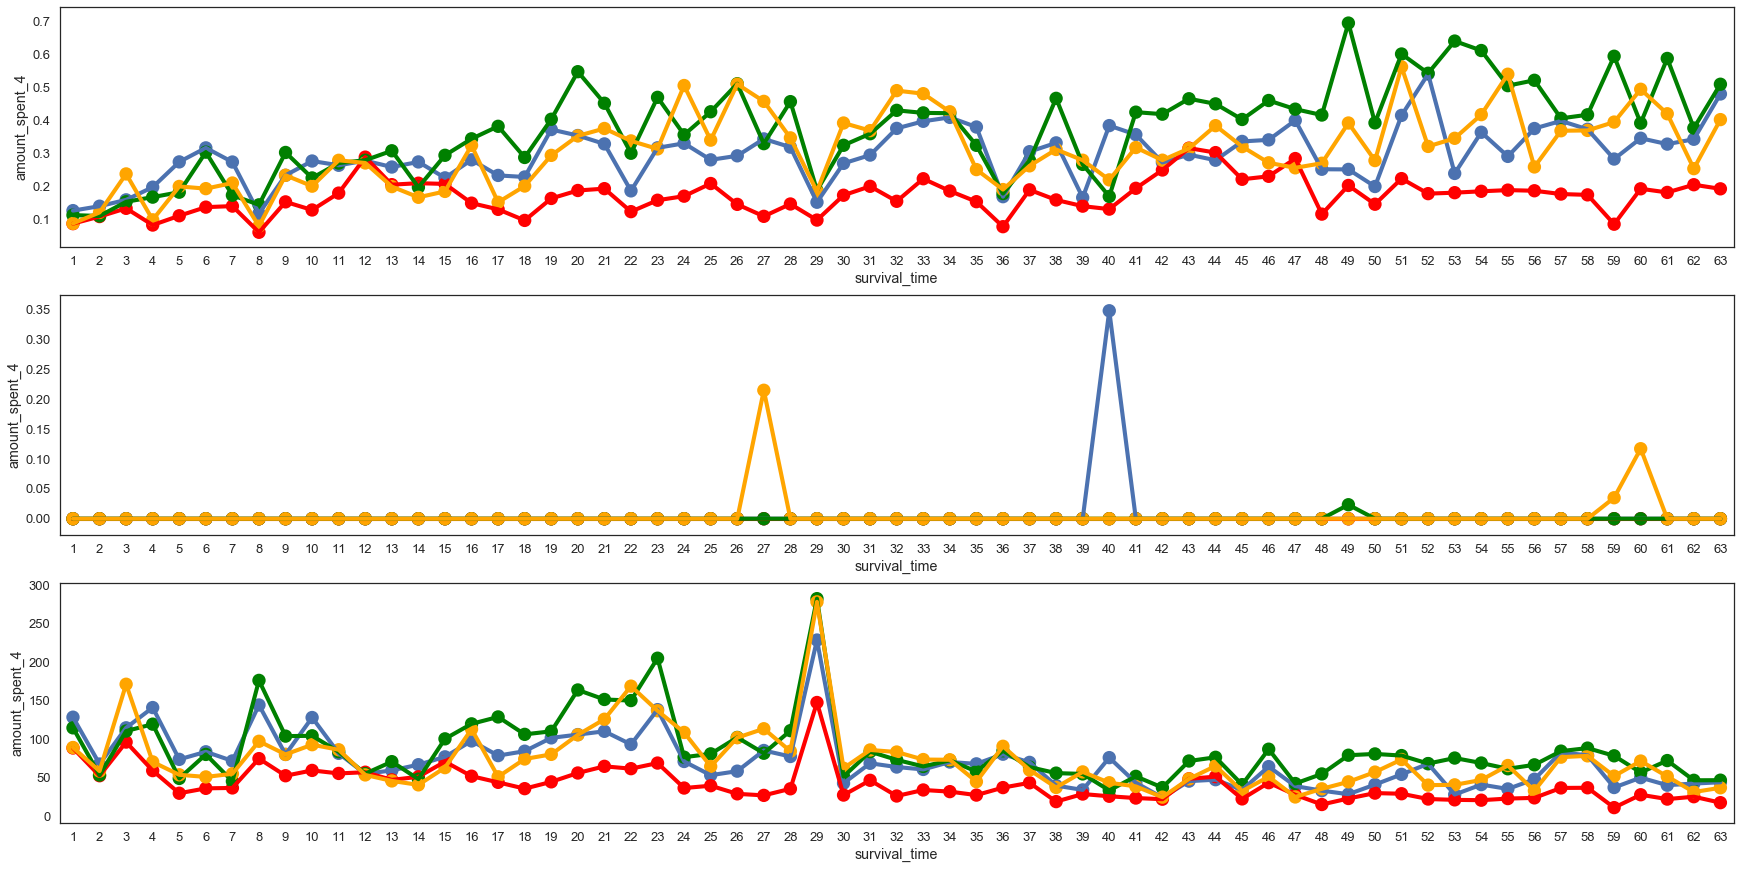

In [134]:
from scipy.stats import gaussian_kde
fig = plt.figure(figsize = (30,15));   
ax1 = fig.add_subplot(311);  
sns.pointplot(data = churn_group, x='survival_time', y='amount_spent_1')
sns.pointplot(data = churn_group, x='survival_time', y='amount_spent_2',color='r')
sns.pointplot(data = churn_group, x='survival_time', y='amount_spent_3',color='g')
sns.pointplot(data = churn_group, x='survival_time', y='amount_spent_4',color='orange')

ax2 = fig.add_subplot(312);  
sns.pointplot(data = churn_group_median, x='survival_time', y='amount_spent_1')
sns.pointplot(data = churn_group_median, x='survival_time', y='amount_spent_2',color='r')
sns.pointplot(data = churn_group_median, x='survival_time', y='amount_spent_3',color='g')
sns.pointplot(data = churn_group_median, x='survival_time', y='amount_spent_4',color='orange')
ax3 = fig.add_subplot(313);  
sns.pointplot(data = churn_group_sum, x='survival_time', y='amount_spent_1')
sns.pointplot(data = churn_group_sum, x='survival_time', y='amount_spent_2',color='r')
sns.pointplot(data = churn_group_sum, x='survival_time', y='amount_spent_3',color='g')
sns.pointplot(data = churn_group_sum, x='survival_time', y='amount_spent_4',color='orange')

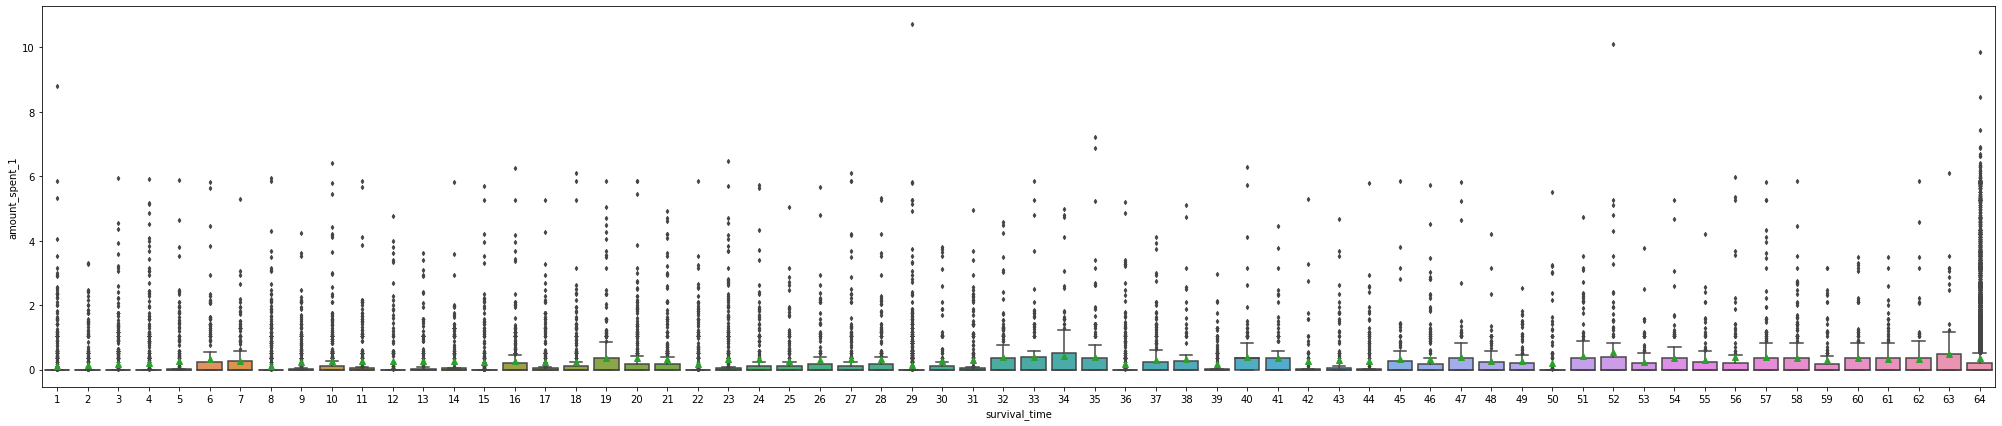

In [63]:
plt.figure(figsize = (35, 7))
sns.boxplot(y = 'amount_spent_1', x = 'survival_time', data = payment, width = 0.8, showmeans = True, fliersize = 3)
plt.show()

## playtime_count (feature selection rank.1)

- 확실히 잔존에 가까울수록 playtime_count의 데이터 분포가 높은쪽에 치우쳐 있음
    - 그러나 명확한 차이를 보이지는 못함
    - 중요한 점!!!!!!!!!!!! : 29일날 이탈자가 실제로 상당수에 다다른다. 29일과 64(잔존)만 playtim_count의 분포가 상당히 높다
      
      이 말은 곧 유저들이 한달 정액을 끊고 열심히 해본 후에 정액을 연장하냐 마냐가 이탈율을 막는 조건이 된다.

In [87]:
dic = {}
for i in range(1,64):
    dic[i] = 1
dic[64] = 0

merge_df['secession'] = merge_df['survival_time'].map(dic)

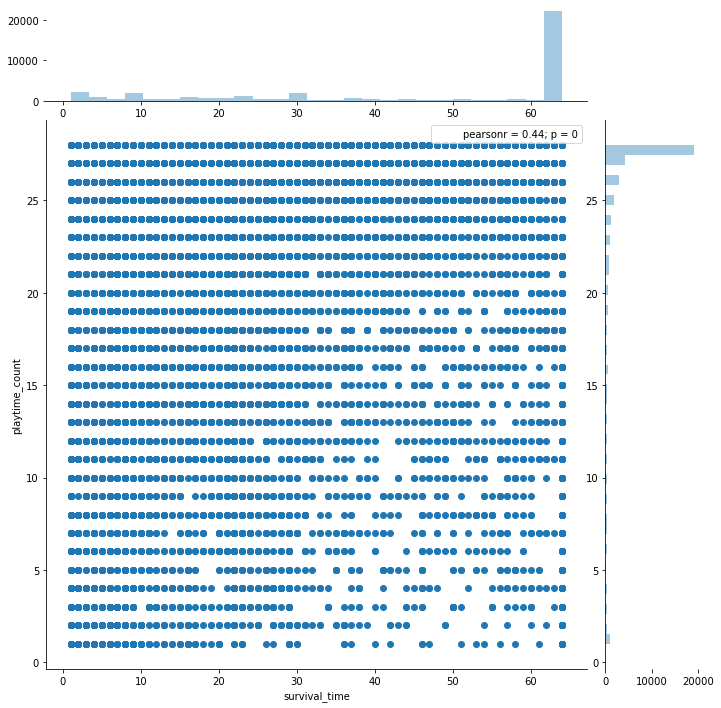

In [89]:
sns.jointplot(x='survival_time', y='playtime_count',data = merge_df, kind='scatter', size = 10)

In [90]:
mm = merge_df.groupby('survival_time').mean().reset_index()

<BarContainer object of 64 artists>

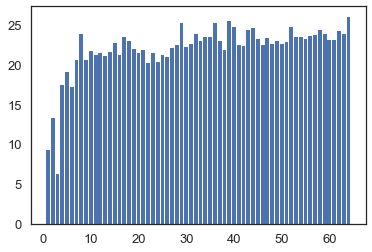

In [181]:
plt.bar(mm.survival_time, mm.playtime_count)

In [95]:
nn = merge_df.groupby('survival_time').sum().reset_index()

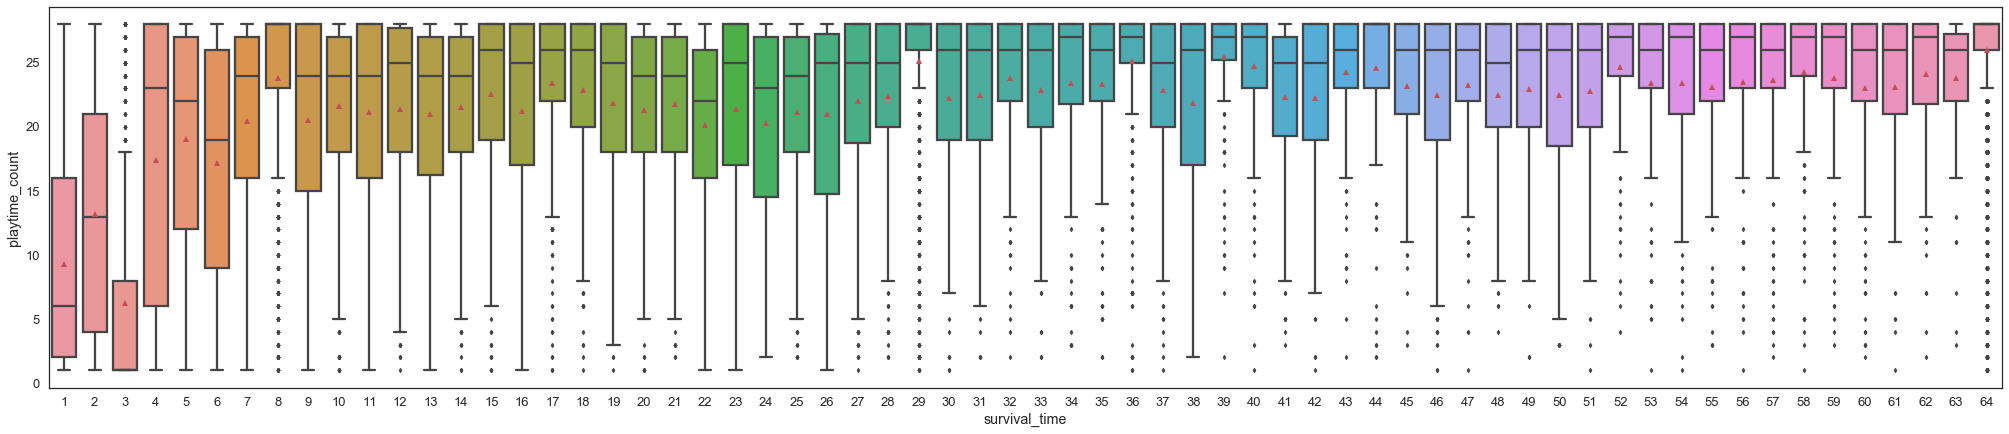

In [120]:
plt.figure(figsize = (35, 7))
sns.boxplot(y = 'playtime_count', x = 'survival_time', data = merge_df, width = 0.8, showmeans = True, fliersize = 3)
plt.show()

In [160]:
merge_df[merge_df.survival_time == 29].playtime_count.mean()

25.156666666666666

In [115]:
aa = pd.DataFrame(merge_df.survival_time.value_counts()).sort_index().reset_index()
aa.rename(columns = {'index':'survival_time', 'survival_time':'freq'}, inplace = True)
aa =aa[aa['survival_time'] != 64]

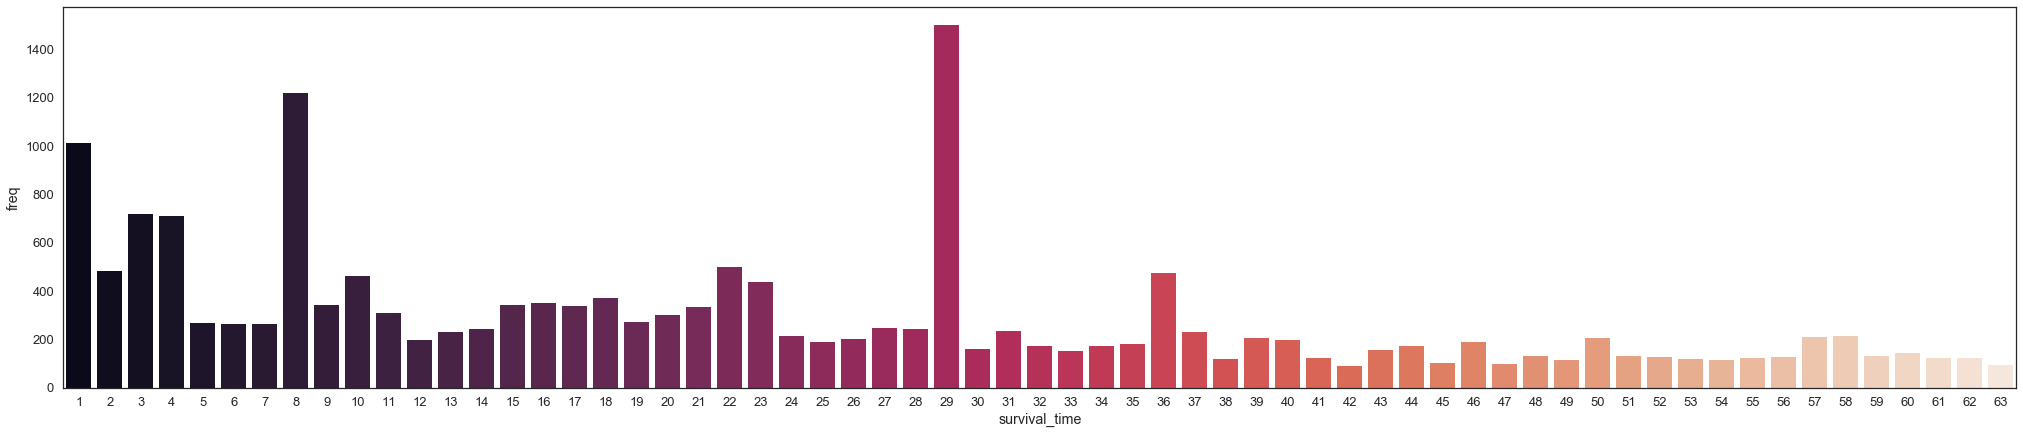

In [118]:
sns.set(style="white", context="talk")
plt.figure(figsize = (35, 7))
sns.barplot(x=aa.survival_time, y = aa.freq, palette="rocket")
# plt.xticks(c='w')

## solo_exp_count (feature selection rank.2)

- 확실히 잔존에 가까울수록 playtime_count의 데이터 분포가 높은쪽에 치우쳐 있음
    - 8일과 29일 잔존한 유저의 freq가 높다
    - playtime_count와 같이 높다.
    - 그말은 즉 혼자 열심히 사냥만하다가 흥미를 잃어 인간의 주기인 일주일 또는 한달 정액 29일에 이탈을 하는 것이 아닐까

C:\ProgramData\Anaconda3\envs\mypython\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


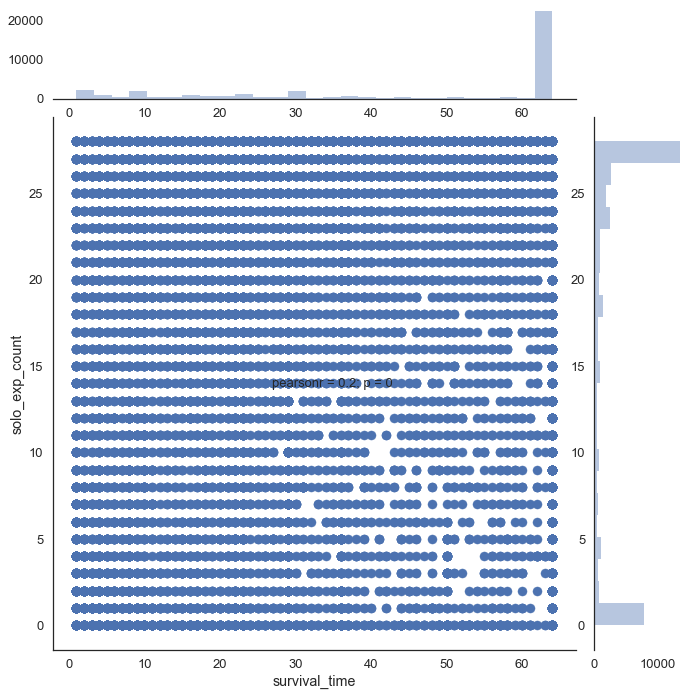

In [136]:
# plt.scatter(merge_df.survival_time, merge_df.solo_exp_count)
sns.jointplot(x='survival_time', y='solo_exp_count',data = merge_df, kind='scatter', size = 10)

In [152]:
mmm = merge_df.groupby('survival_time').mean().reset_index()
mmm = mmm[mmm.survival_time != 64]
nnn = merge_df.groupby('survival_time').std().reset_index()

<BarContainer object of 64 artists>

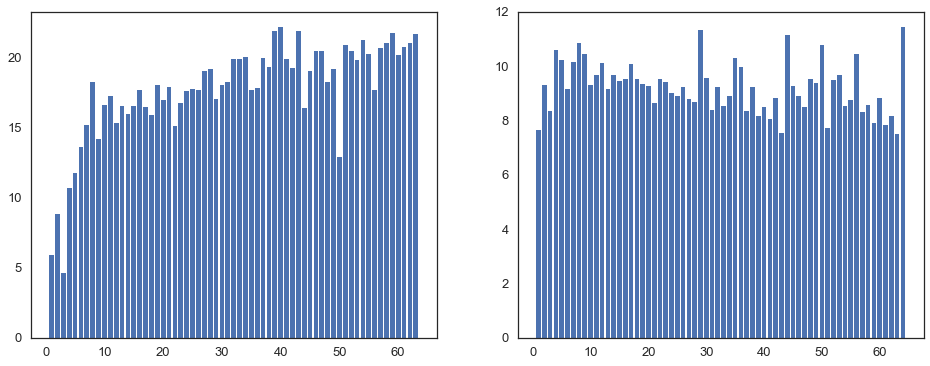

In [154]:
fig = plt.figure(figsize = (16,6));   
ax1 = fig.add_subplot(121);  
plt.bar(mmm.survival_time, mmm.solo_exp_count)
ax2 = fig.add_subplot(122);  
plt.bar(nnn.survival_time, nnn.solo_exp_count)

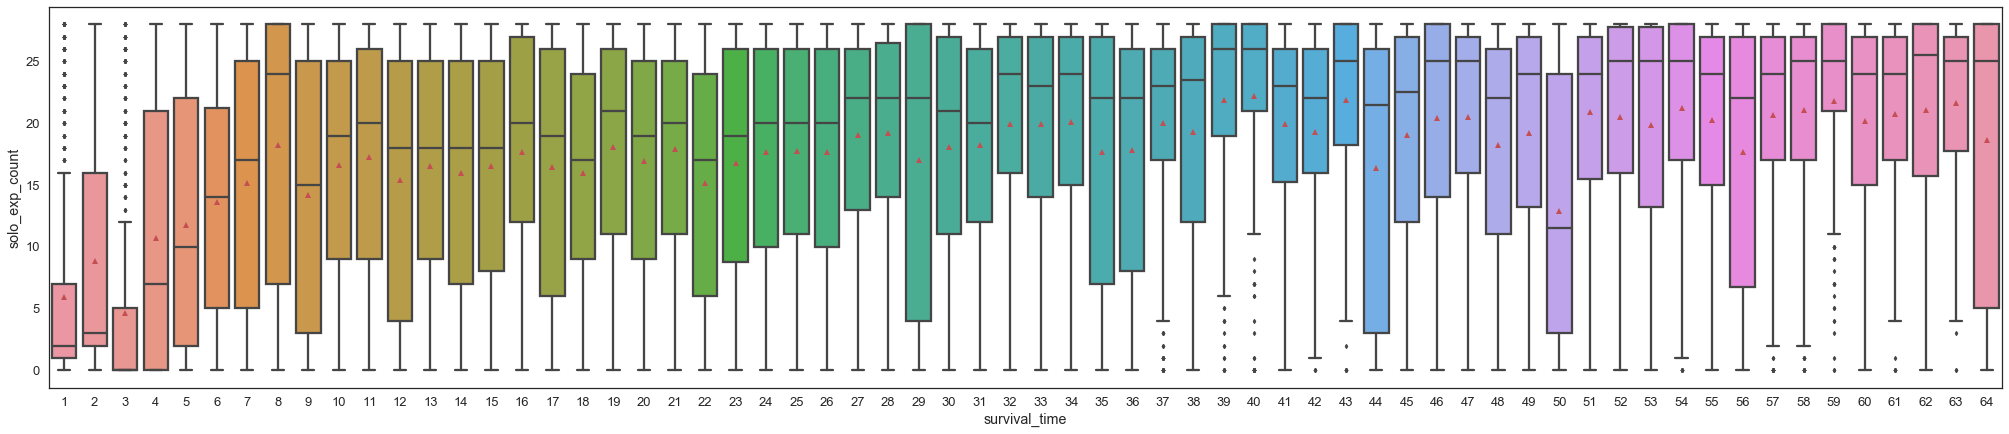

In [137]:
plt.figure(figsize = (35, 7))
sns.boxplot(y = 'solo_exp_count', x = 'survival_time', data = merge_df, width = 0.8, showmeans = True, fliersize = 3)
plt.show()

## quest_exp_count (feature selection rank.3)

- 이탈율이 높은 8일과 29일의 퀘스트 수행 횟수가 상당히 적다.
    - 플레이타임은 눈에 띄게 높고, 솔로사냥 빈도는 비슷하고, 퀘스트꺠는 정도는 현저하게 낮고

C:\ProgramData\Anaconda3\envs\mypython\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


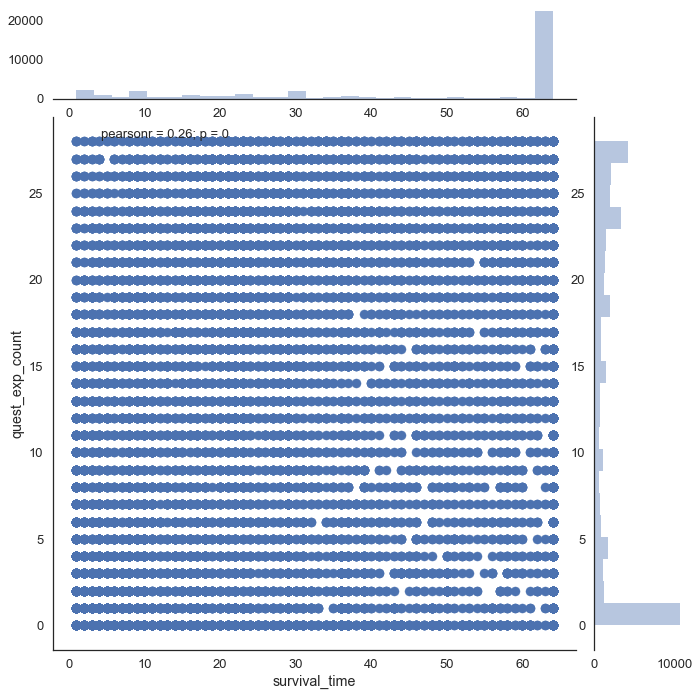

In [143]:
sns.jointplot(x='survival_time', y='quest_exp_count',data = merge_df, kind='scatter', size = 10)

<BarContainer object of 64 artists>

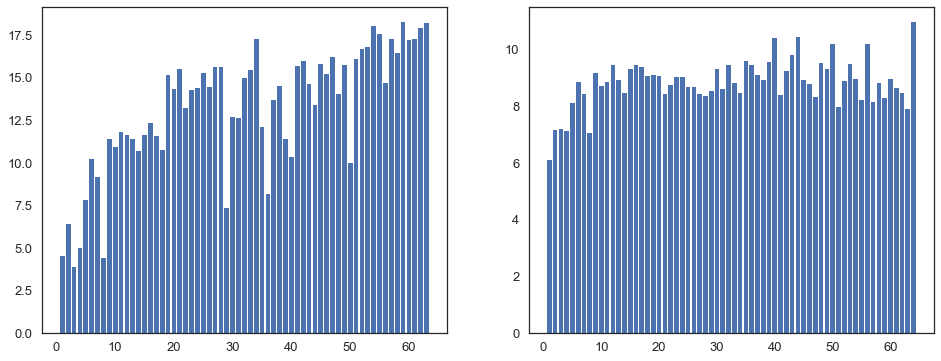

In [155]:

fig = plt.figure(figsize = (16,6));   
ax1 = fig.add_subplot(121);  
plt.bar(mmm.survival_time, mmm.quest_exp_count)
ax2 = fig.add_subplot(122);  
plt.bar(nnn.survival_time, nnn.quest_exp_count)

In [161]:
merge_df[merge_df.survival_time == 29].quest_exp_count.mean()

7.330666666666667

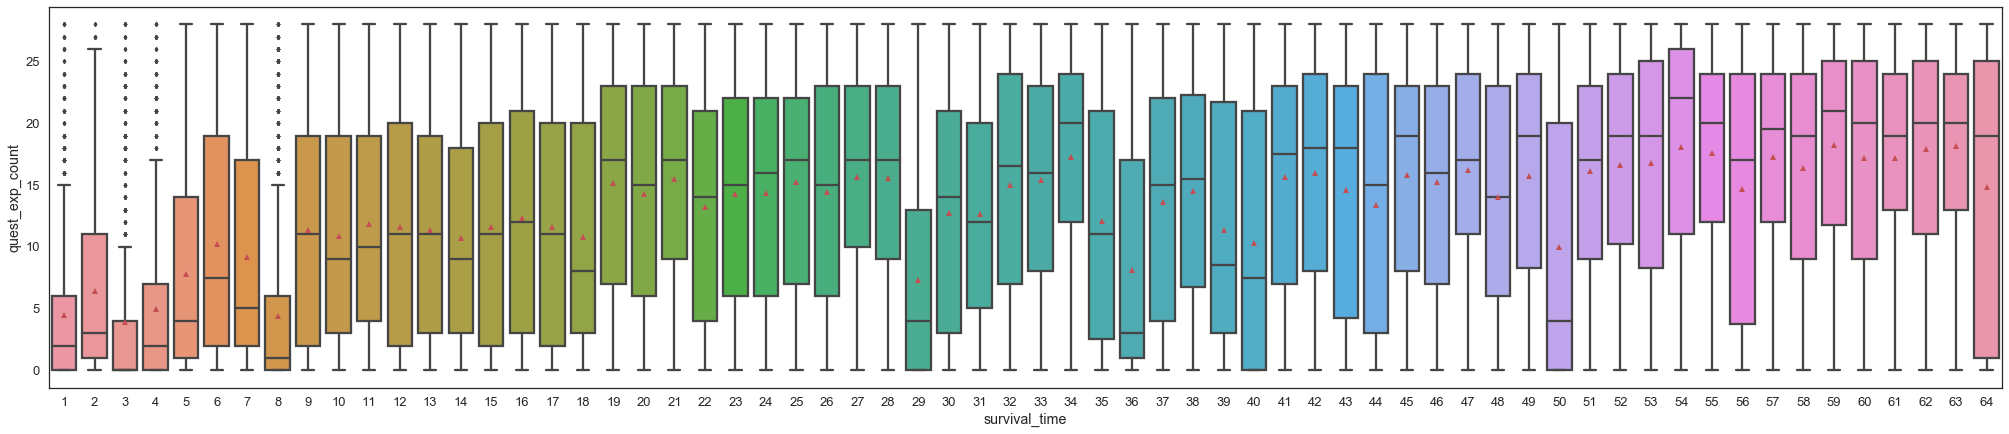

In [145]:
plt.figure(figsize = (35, 7))
sns.boxplot(y = 'quest_exp_count', x = 'survival_time', data = merge_df, width = 0.8, showmeans = True, fliersize = 3)
plt.show()

## plus_am (feature selection rank.6)

- 이탈율이 높은 8일과 29일의 퀘스트 수행 횟수가 상당히 적다.
    - 플레이타임은 눈에 띄게 높고, 솔로사냥 빈도는 비슷하고, 퀘스트꺠는 정도는 현저하게 낮고

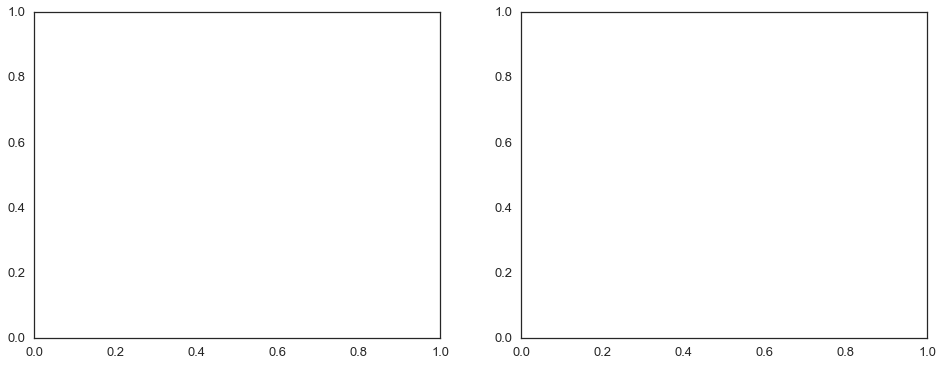

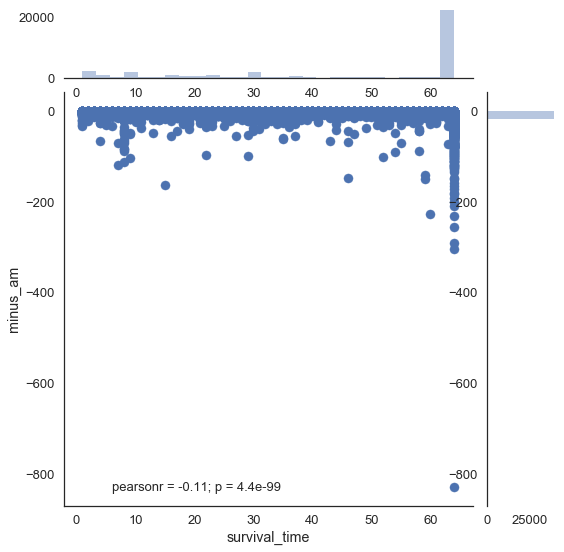

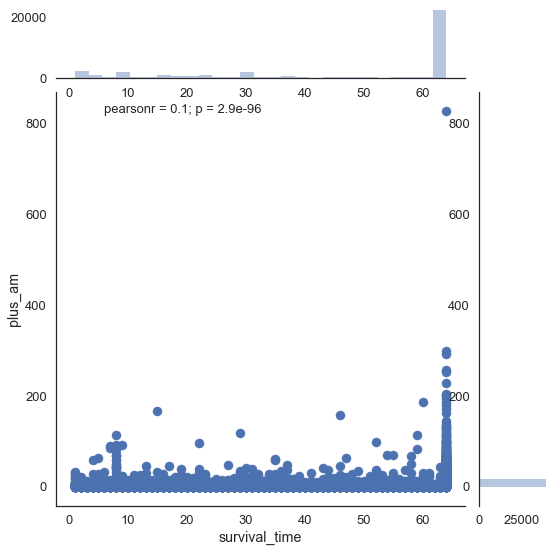

In [168]:
fig = plt.figure(figsize = (16,6));   
ax1 = fig.add_subplot(121);  
sns.jointplot(x='survival_time', y='minus_am',data = merge_df, kind='scatter', size = 8)
ax2 = fig.add_subplot(122);  
sns.jointplot(x='survival_time', y='plus_am',data = merge_df, kind='scatter', size = 8)

<BarContainer object of 64 artists>

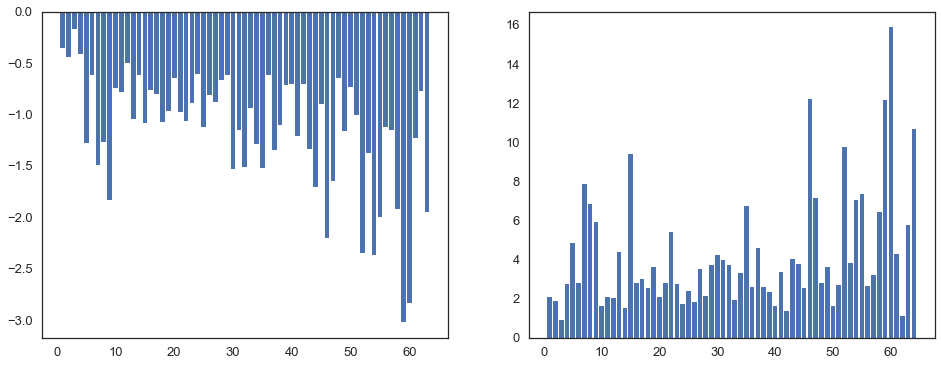

In [169]:
fig = plt.figure(figsize = (16,6));   
ax1 = fig.add_subplot(121);  
plt.bar(mmm.survival_time, mmm.minus_am)
ax2 = fig.add_subplot(122);  
plt.bar(nnn.survival_time, nnn.plus_am)

In [175]:
aaaa = merge_df[merge_df.survival_time != 64]

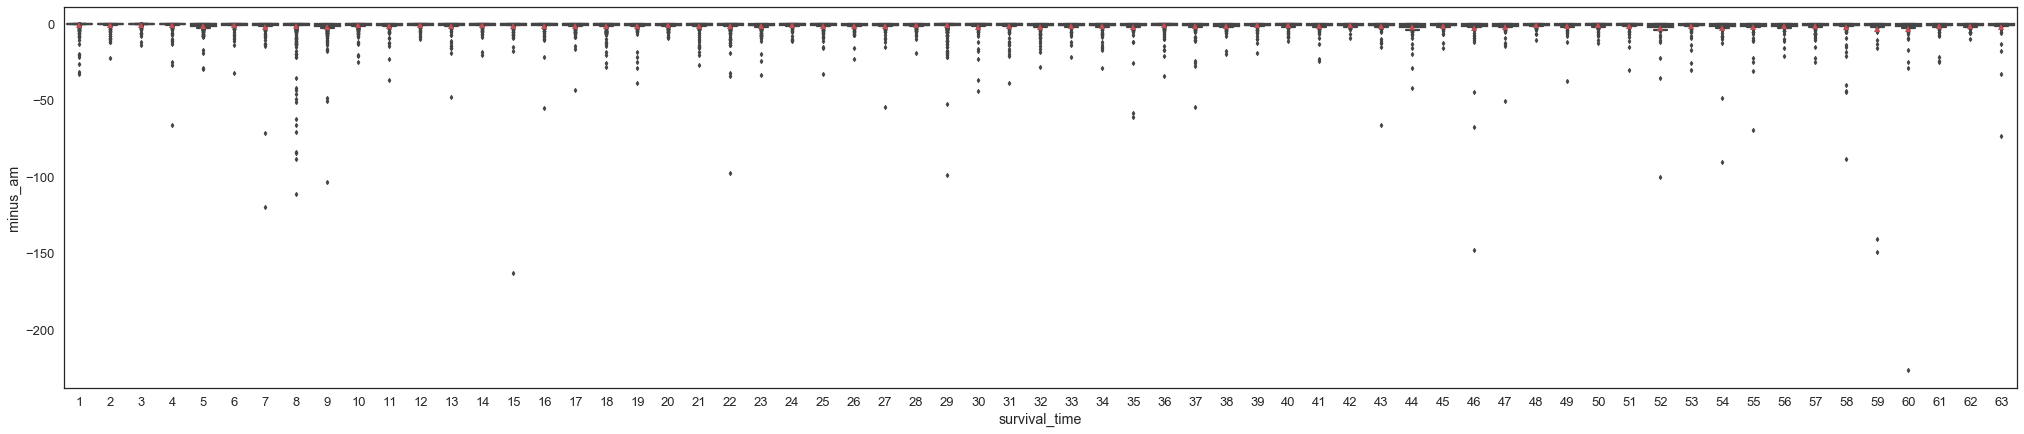

In [176]:
plt.figure(figsize = (35, 7))
sns.boxplot(y = 'minus_am', x = 'survival_time', data = aaaa, width = 0.8, showmeans = True, fliersize = 3)
plt.show()

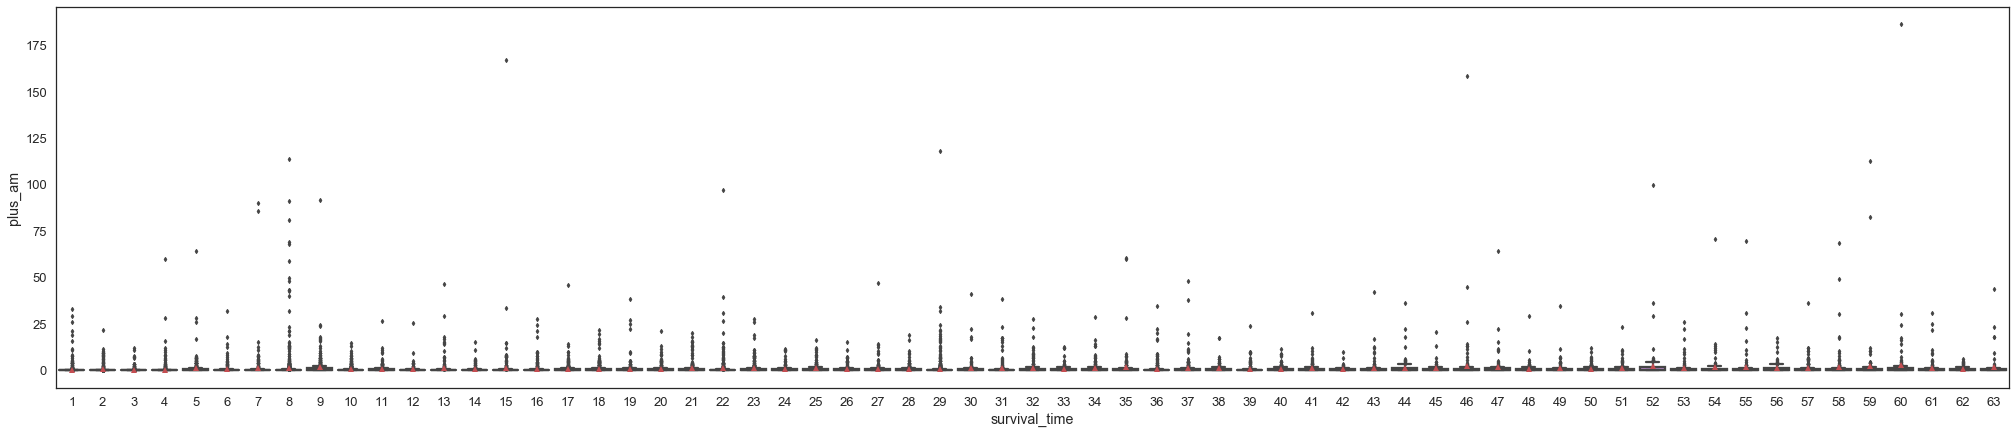

In [177]:
plt.figure(figsize = (35, 7))
sns.boxplot(y = 'plus_am', x = 'survival_time', data = aaaa, width = 0.8, showmeans = True, fliersize = 3)
plt.show()

C:\ProgramData\Anaconda3\envs\mypython\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


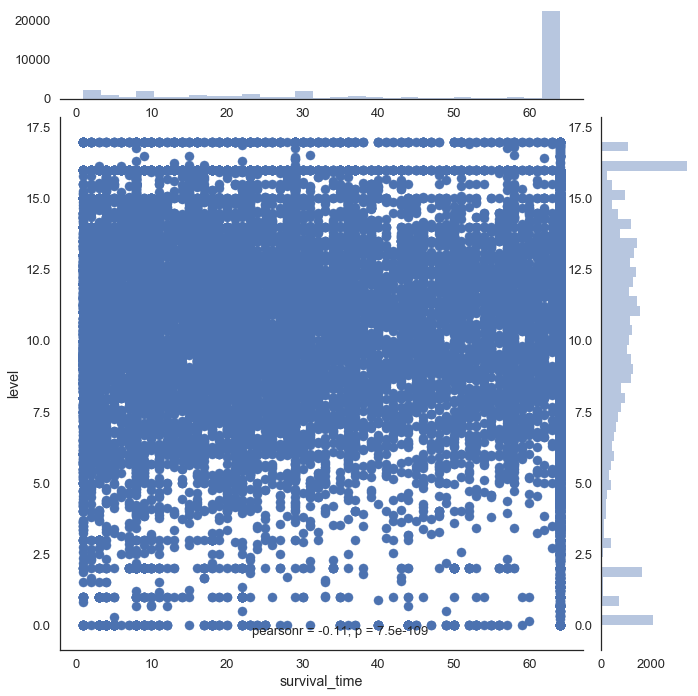

In [178]:
sns.jointplot(x='survival_time', y='level',data = merge_df, kind='scatter', size = 10)

<BarContainer object of 64 artists>

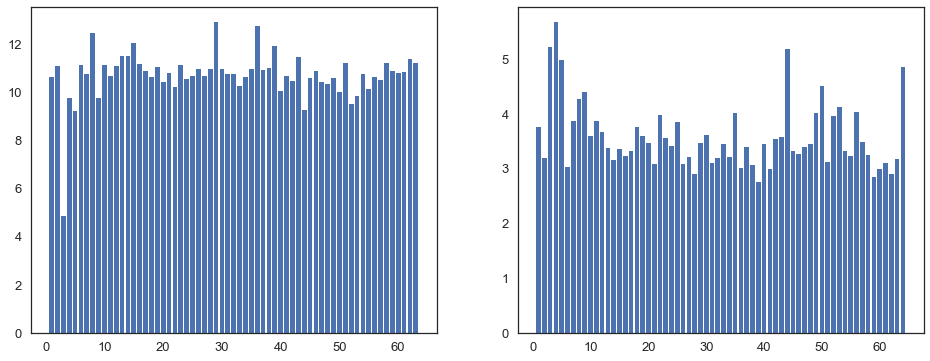

In [179]:

fig = plt.figure(figsize = (16,6));   
ax1 = fig.add_subplot(121);  
plt.bar(mmm.survival_time, mmm.level)
ax2 = fig.add_subplot(122);  
plt.bar(nnn.survival_time, nnn.level)

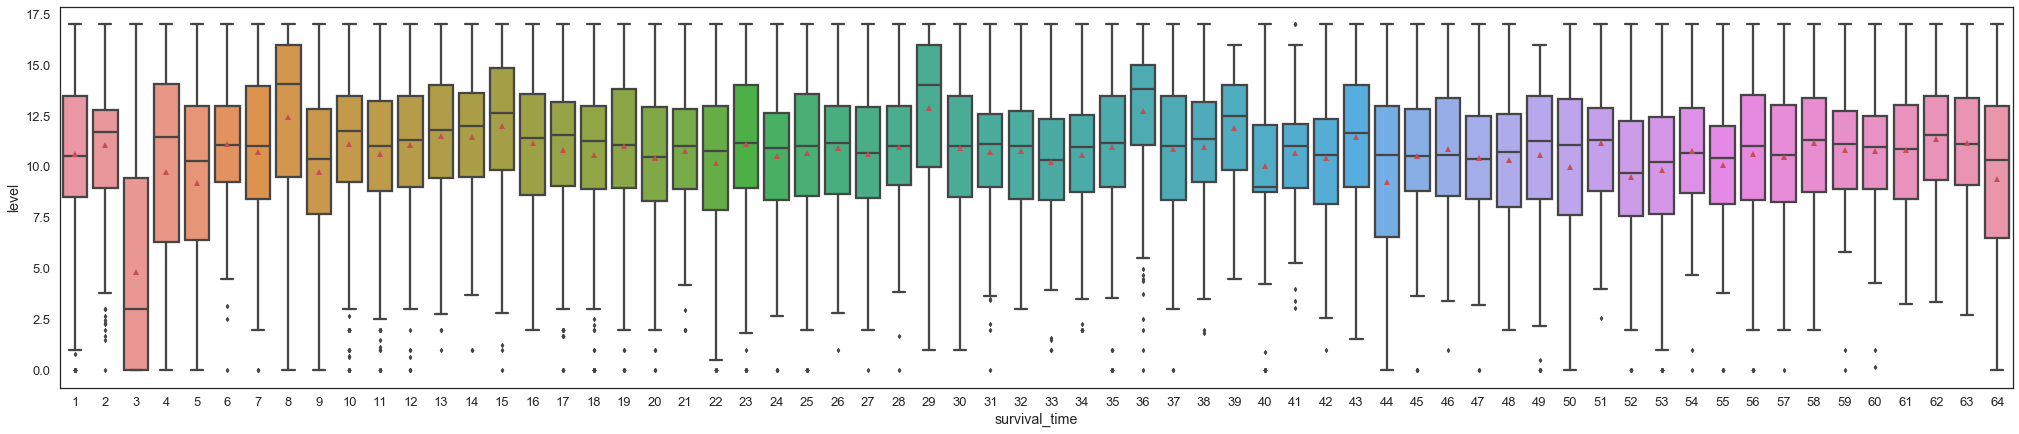

In [180]:
plt.figure(figsize = (35, 7))
sns.boxplot(y = 'level', x = 'survival_time', data = merge_df, width = 0.8, showmeans = True, fliersize = 3)
plt.show()

C:\ProgramData\Anaconda3\envs\mypython\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


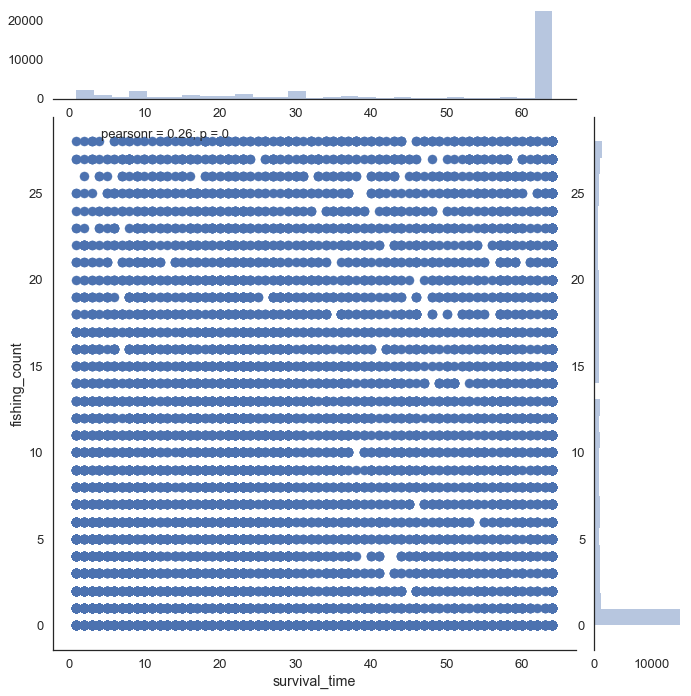

In [182]:
sns.jointplot(x='survival_time', y='fishing_count',data = merge_df, kind='scatter', size = 10)

<BarContainer object of 64 artists>

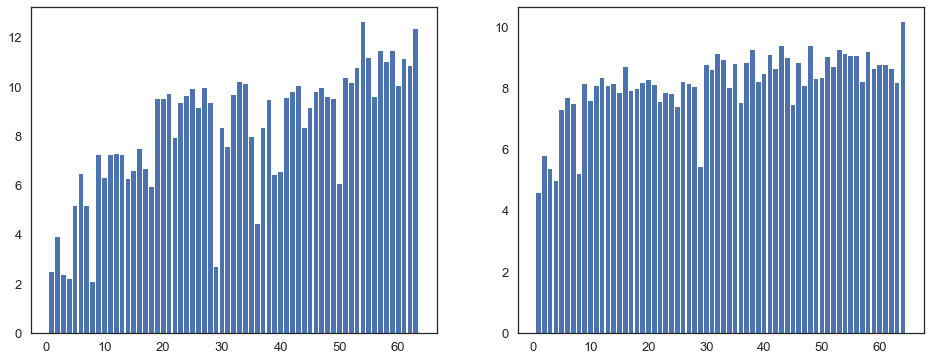

In [183]:

fig = plt.figure(figsize = (16,6));   
ax1 = fig.add_subplot(121);  
plt.bar(mmm.survival_time, mmm.fishing_count)
ax2 = fig.add_subplot(122);  
plt.bar(nnn.survival_time, nnn.fishing_count)

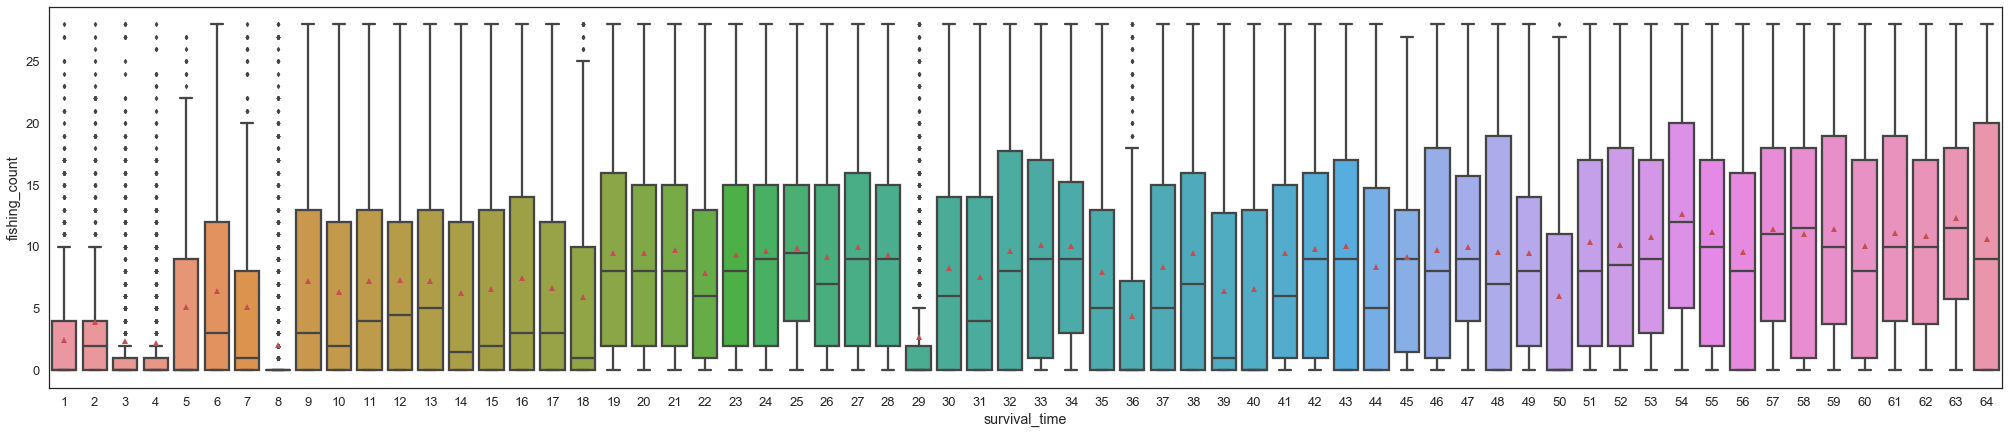

In [184]:
plt.figure(figsize = (35, 7))
sns.boxplot(y = 'fishing_count', x = 'survival_time', data = merge_df, width = 0.8, showmeans = True, fliersize = 3)
plt.show()

In [187]:
plg = merge_df[merge_df.play_char_cnt !=0]

In [191]:
merge_df['have_pledge'] = np.where(merge_df.play_char_cnt >0,1,0)

In [193]:
merge_df[merge_df.have_pledge ==0].survival_time.value_counts()

64    4479
1      234
8      106
3       98
22      83
2       71
9       67
5       60
29      56
10      47
18      45
20      44
4       44
7       43
23      41
44      36
6       33
17      32
21      24
11      23
19      22
15      20
57      18
14      18
35      18
30      17
12      17
13      17
25      17
16      17
      ... 
26      14
32      14
27      14
37      12
46      12
31      12
49      10
28      10
60      10
40      10
24      10
34      10
55      10
47       8
48       7
63       7
33       7
51       7
52       6
62       6
43       6
42       5
50       5
54       5
45       4
59       4
38       4
39       4
41       3
61       2
Name: survival_time, Length: 64, dtype: int64

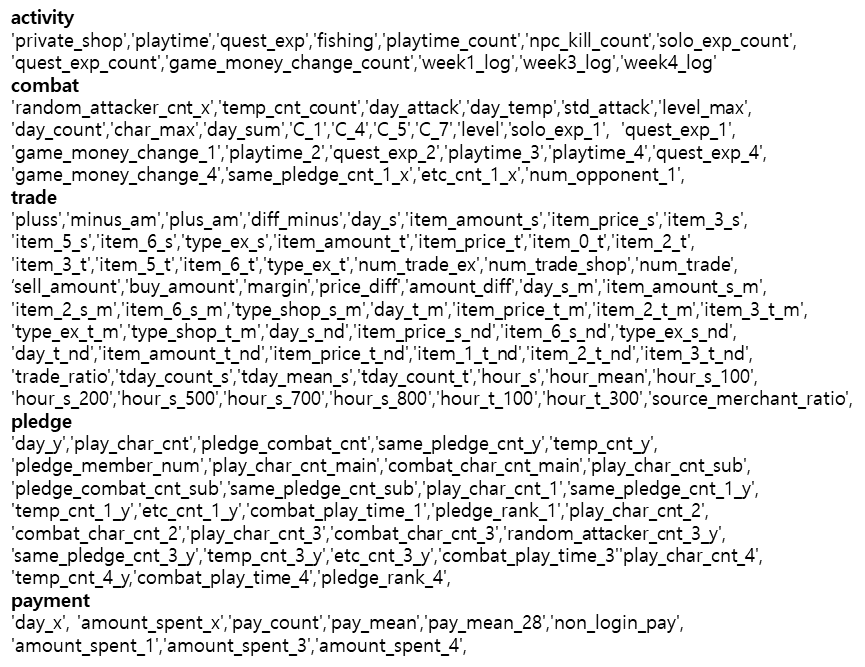